In [1]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

def plot_histogram(data,numberofbins,label,minimum,maximum):
    bins = np.linspace(minimum, maximum, numberofbins)
    bin_probabilities = np.histogram(data,bins)[0]/len(data)
    leftedges = bins[:-1]
    rightedges = bins[1:]
    widths = np.array(rightedges)-np.array(leftedges)
    plt.bar(leftedges,bin_probabilities,width=widths,align='edge',label=label,alpha=0.5)
    binmidvalues = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

In [2]:
class Person(object):
    def __init__(self,starting_x,starting_y,walk_method,min_x,max_x,min_y,max_y):
        self.status = 0 #0 = Health, 1 = Infected, 2 = Immune
        self.x = starting_x
        self.y = starting_y
        self.days_ill = 0
        self.walk_method = walk_method #'Random_single_walk'
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
    def get_position(self):
        return [self.x,self.y]
    def get_status(self):
        return self.status
    def get_days_ill(self):
        return self.days_ill
    def infect_self(self):
        if self.status == 0:
            self.status = 1
    def perform_walk(self):
        if self.walk_method == 'Random_single_walk':
            thingtodo = np.random.randint(0,5)
            if thingtodo == 1:# Walk left
                self.x = max(self.min_x,self.x - 1)
            elif thingtodo == 2:# Walk right
                self.x = min(self.max_x,self.x+1)
            elif thingtodo == 3:# Walk up
                self.y = min(self.max_y,self.y+1)
            elif thingtodo == 4:# Walk down
                self.y = max(self.min_y,self.y-1)
    def update_sick_days(self):
        if self.status == 1:
            self.days_ill = self.days_ill+1
            if self.days_ill >= 20:
                self.status = 2
                
    def calculate_distance(self,agent2):
        agent1x,agent1y = self.get_position()
        agent2x,agent2y = agent2.get_position()
        return np.sqrt((agent2x-agent1x)**2+(agent2y-agent1y)**2)
                
                
class Simulation(object):
    def __init__(self,N,min_x,max_x,min_y,max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.N = N
        self.healthy_agents = []
        self.sick_agents = []
        self.immune_agents = []
        self.results = {'healthy':[N-1],'sick':[1],'immune':[0]}
        self.days_run = 0
        self.best_infect_chance = (1/5)
        #Insert initial sick Person
        self.sick_agents.append(Person(np.random.randint(self.min_x,self.max_x+1),
                                       np.random.randint(self.min_y,self.max_y+1),
                                       'Random_single_walk',
                                       self.min_x,self.max_x,self.min_y,self.max_y))
        self.sick_agents[0].infect_self()
        self.sick_agents[0].update_sick_days()
        #Insert healthy persons
        for i in range(N-1):
            self.healthy_agents.append(Person(np.random.randint(self.min_x,self.max_x+1),
                                       np.random.randint(self.min_y,self.max_y+1),
                                       'Random_single_walk',
                                       self.min_x,self.max_x,self.min_y,self.max_y))        
    def perform_walk_step(self):
        for a in self.healthy_agents:
            a.perform_walk()
        for a in self.sick_agents:
            a.perform_walk()
        for a in self.immune_agents:
            a.perform_walk()
    def change_infect_chance(self,chance):
        self.best_infect_chance = chance
    def perform_infection_step(self):
        new_healthy = []
        additional_sick = []
        for healthy in self.healthy_agents:
            for sick in self.sick_agents:
                #Calculate distance
                distance_sqr = healthy.calculate_distance(sick)**2
                prob_infect = (self.best_infect_chance)*np.exp(-distance_sqr/10)
                random_number = np.random.rand()
                if random_number <= prob_infect:
                    healthy.infect_self()
                    # additional_sick.append(healthy)
                    break
            if healthy.get_status() == 0:
                new_healthy.append(healthy)
            elif healthy.get_status() == 1:
                additional_sick.append(healthy)
        self.sick_agents = self.sick_agents + additional_sick
        self.healthy_agents = new_healthy
    def update_days_for_sick(self):
        new_sick = []
        additional_immune = []
        for sick in self.sick_agents:
            sick.update_sick_days()
            if sick.get_status() == 2:
                additional_immune.append(sick)
            elif sick.get_status() == 1:
                new_sick.append(sick)
        self.immune_agents = self.immune_agents + additional_immune
        self.sick_agents = new_sick
    def admin_check_number_agents(self):
        calc_N = len(self.healthy_agents) + len(self.sick_agents) + len(self.immune_agents)
        if calc_N != self.N:
            raise Exception('Number of Agents not Conserved!')
    def get_number_healthy(self):
        return len(self.healthy_agents)
    def get_number_sick(self):
        return len(self.sick_agents)
    def get_number_immune(self):
        return len(self.immune_agents)
    def run(self,days_to_run):
        for d in range(days_to_run):
            self.days_run = self.days_run + 1
            self.perform_walk_step()
            self.perform_infection_step()
            self.update_days_for_sick()
            self.results['healthy'].append(self.get_number_healthy())
            self.results['sick'].append(self.get_number_sick())
            self.results['immune'].append(self.get_number_immune())
    def get_results(self):
        return self.results
    
class Experiment(object):
    def __init__(self,number_simulations,infect_chance,N,min_x,max_x,min_y,max_y):
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.N = N
        self.number_simulations = number_simulations
        self.infect_chance = infect_chance
        self.simulations = []
        self.days_run = 0
        self.run_already = False
        for i in range(self.number_simulations):
            a = Simulation(self.N,self.min_x,self.max_x,self.min_y,self.max_y)
            a.change_infect_chance(self.infect_chance)
            self.simulations.append(a)
    def run_func_for_parallel(self,days):
        a = Simulation(self.N,self.min_x,self.max_x,self.min_y,self.max_y)
        a.run(days)
        return a
    def run_forward_for_x_days(self,x):
        if self.run_already == False:
            self.days_run = x
            self.run_already = True
            simulations = Parallel(n_jobs=4)(delayed(self.run_func_for_parallel)(x) for a in tqdm(range(self.number_simulations)))
            self.simulations = simulations
    def get_results(self):
        # print('Extracting Results')
        results = {'healthy':[],'sick':[],'immune':[]}
        for sim in self.simulations:
            res = sim.get_results()
            results['healthy'].append(res['healthy'])
            results['sick'].append(res['sick'])
            results['immune'].append(res['immune'])
        results['healthy'] = np.array(results['healthy'])
        results['sick'] = np.array(results['sick'])
        results['immune'] = np.array(results['immune'])
        return results
    def get_results_average(self):
        res = self.get_results()
        healthy = np.sum(res['healthy'],axis=0)
        sick = np.sum(res['sick'],axis=0)
        immune = np.sum(res['immune'],axis=0)
        total = healthy+sick+immune
        return {'healthy':healthy/total,'sick':sick/total,'immune':immune/total}

    def get_distribution_max_sick(self):
        res = self.get_results()
        sick = np.amax(res['sick'],axis=1)
        return sick

    def get_distribution_max_sick_day(self):
        res = self.get_results()
        sick_data = res['sick']
        max_sicks = np.amax(res['sick'],axis=1)
        max_sick_days = []
        for i in range(len(max_sicks)):
            max_sick_days.append(np.where(sick_data[i]==max_sicks[i])[0][0])
        return np.array(max_sick_days)

    def get_distribution_max_immune(self):
        res = self.get_results()
        immune = np.amax(res['immune'],axis=1)
        return immune

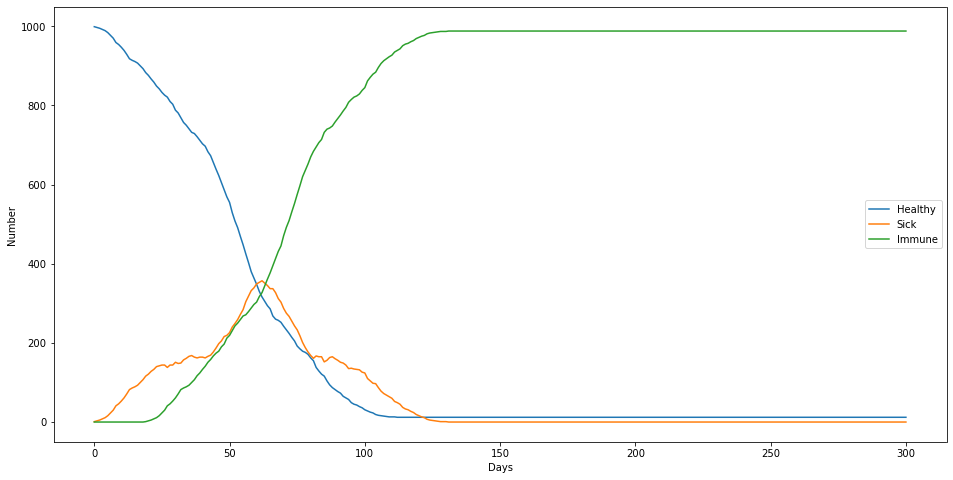

In [3]:
#Ok, everything works, now lets do some simulations

a = Simulation(1000,-50,50,-50,50)
a.run(300)
results = a.get_results()
healthy = results['healthy']
sick = results['sick']
immune = results['immune']
plt.figure(figsize=(16, 8))
plt.plot(healthy,label='Healthy')
plt.plot(sick,label='Sick')
plt.plot(immune,label='Immune')
plt.xlabel('Days')
plt.ylabel('Number')
plt.legend()

In [14]:
#Lets do a run of 100 simulations 
a = Experiment(100,(1/5),1000,-50,50,-50,50)
# a.run_func_for_parallel(10,100)
a.run_forward_for_x_days(300)
result = a.get_results()




  0%|          | 0/100 [00:00<?, ?it/s]


  4%|▍         | 4/100 [00:00<00:02, 39.46it/s]


  8%|▊         | 8/100 [00:04<01:00,  1.52it/s]


 10%|█         | 10/100 [00:04<00:44,  2.03it/s]

KeyboardInterrupt: 

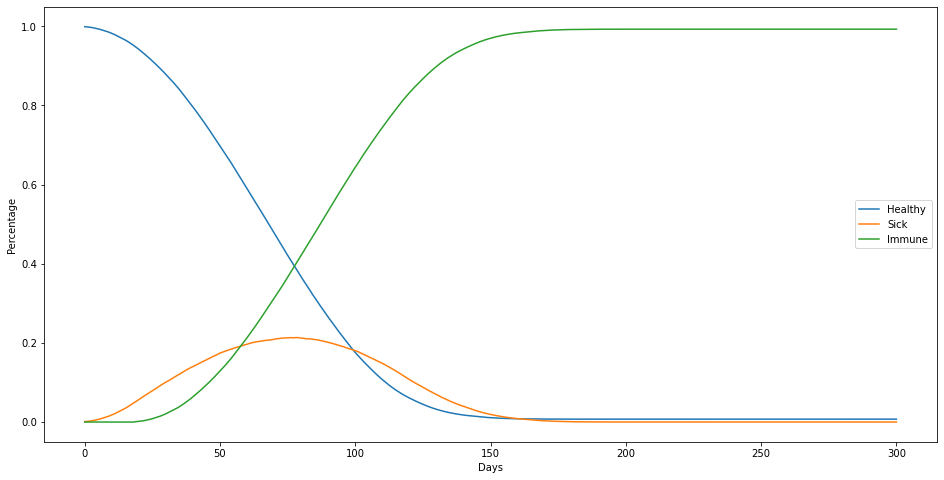

In [6]:
ave_results = a.get_results_average()
plt.figure(figsize=(16, 8))
plt.plot(ave_results['healthy'],label='Healthy')
plt.plot(ave_results['sick'],label='Sick')
plt.plot(ave_results['immune'],label='Immune')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

In [7]:
dist_max_sick = a.get_distribution_max_sick()

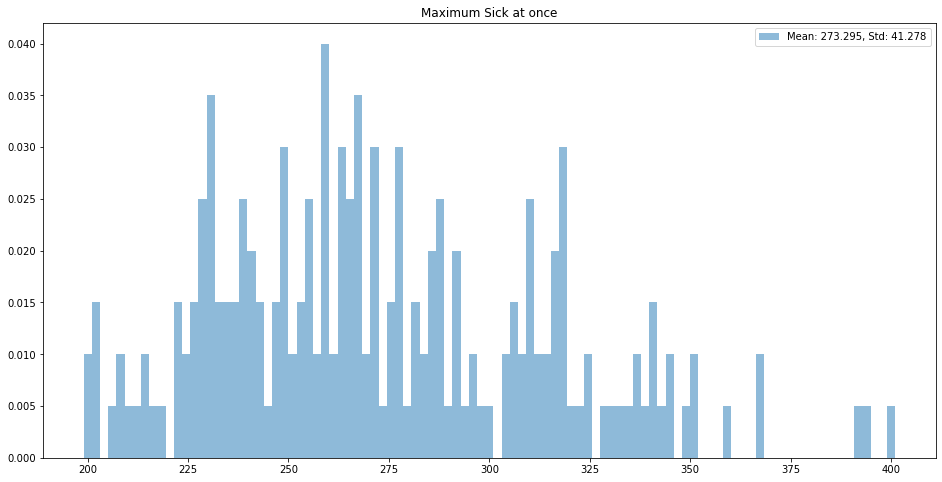

In [8]:
plt.figure(figsize=(16, 8))
plot_histogram(dist_max_sick,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_max_sick),3),np.round(np.std(dist_max_sick),3)),np.amin(dist_max_sick),np.amax(dist_max_sick))
plt.title('Maximum Sick at once')
plt.legend()

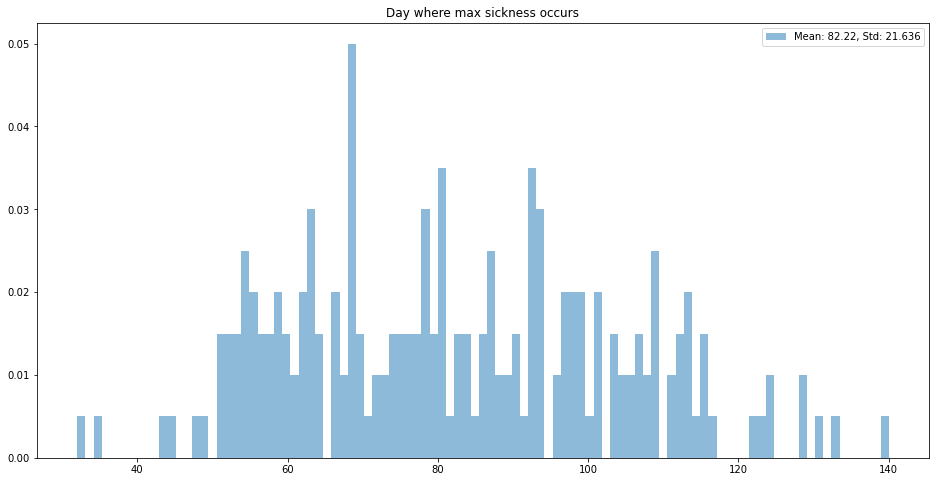

In [9]:
dist_day_max_sick = a.get_distribution_max_sick_day()
plt.figure(figsize=(16, 8))
plot_histogram(dist_day_max_sick,100,'Mean: %s, Std: %s'%(np.round(np.mean(dist_day_max_sick),3),np.round(np.std(dist_day_max_sick),3)),np.amin(dist_day_max_sick),np.amax(dist_day_max_sick))
plt.title('Day where max sickness occurs')
plt.legend()

In [13]:
#Now lets try out simulations with larger N

exp_N2000 = Experiment(100,(1/5),2000,-50,50,-50,50)
# a.run_func_for_parallel(10,100)
exp_N2000.run_forward_for_x_days(300)
result = exp_N2000.get_results()



  0%|          | 0/100 [00:00<?, ?it/s]

  8%|▊         | 8/100 [01:19<15:15,  9.95s/it]

KeyboardInterrupt: 